In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt



In [3]:
print("GPUs available:", tf.config.list_physical_devices('GPU'))

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# -------------------------
# 1. Load and preprocess data
# -------------------------

data_2017 = "Magaza CSV Files 2017/magaza_1096_2017.csv"
data_2018 = "Magaza CSV Files 2018/magaza_1096_2018.csv"
data_2019 = "Magaza CSV Files 2019/magaza_1096_2019.csv"

df_2017 = pd.read_csv(data_2017)
df_2018 = pd.read_csv(data_2018)
df_2019 = pd.read_csv(data_2019)

data = pd.concat([df_2017, df_2018])
data = data.sort_values('tarih')
data.set_index('tarih', inplace=True)

sales = data[['toplam_satis_adet']]

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sales = scaler.fit_transform(sales)

print(data.head(10))

            magaza_no   mal_no  toplam_satis_tl  toplam_satis_adet
tarih                                                             
2017-01-01       1096  8010701            87.40                 42
2017-01-02       1096  8010701            77.03                 37
2017-01-03       1096  8010701           102.03                 49
2017-01-04       1096  8010701            43.71                 21
2017-01-05       1096  8010701            72.88                 35
2017-01-06       1096  8010701           110.31                 53
2017-01-07       1096  8010701           106.17                 51
2017-01-08       1096  8010701           112.44                 54
2017-01-09       1096  8010701           122.85                 59
2017-01-10       1096  8010701            64.52                 31


In [5]:
# -------------------------
# 2. Create time-series dataset (sliding window)
# -------------------------
def create_dataset(series, window_size=30):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

# Define the window size (e.g., 30 days)
window_size = 30
X, y = create_dataset(scaled_sales, window_size)

In [6]:
# -------------------------
# 3. Train-Test Split
# -------------------------
# For evaluation, we use the last 7 days of the two-year period as test set.
train_size = len(X) - 7
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [7]:
# -------------------------
# 4. Build the LSTM model with Hyperparameter Optimization using Keras Tuner
# -------------------------
def build_model(hp):
    model = Sequential()
    # Tune the number of LSTM units: between 32 and 256
    units = hp.Int('units', min_value=32, max_value=256, step=32)
    model.add(LSTM(units=units, activation='tanh',
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    # Optionally tune dropout rate
    dropout_rate = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='sales_forecast'
)
with tf.device('/GPU:0'):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop], verbose=1)

    best_model = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from my_dir/sales_forecast/tuner0.json


2025-03-22 15:16:13.200348: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-03-22 15:16:13.200391: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-03-22 15:16:13.200400: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-03-22 15:16:13.200441: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-22 15:16:13.200451: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/mertgoker/Documents/GitHub/Senior-Design-Project/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argu

In [8]:
# -------------------------
# 5. Evaluate the model on test set
# -------------------------
# Predict on test set
y_pred_scaled = best_model.predict(X_test)
# Inverse transform the predictions and true values
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # expressed in percent

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAPE: {mape:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Test RMSE: 42.77
Test MAPE: 32.44%


2025-03-22 15:16:17.035096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [10]:
# -------------------------
# 6. Forecast the First Week of the Third Year
# -------------------------
# To forecast beyond the available data, we take the last available window from the two-year dataset.
last_window = scaled_sales[-window_size:]

def forecast_future(model, last_window, forecast_horizon=7):
    forecast = []
    current_window = last_window.copy()
    for i in range(forecast_horizon):
        # model expects input shape (1, window_size, features)
        pred_scaled = model.predict(current_window[np.newaxis, :, :])
        forecast.append(pred_scaled[0, 0])
        current_window = np.append(current_window[1:], [[pred_scaled[0, 0]]], axis=0)
    return np.array(forecast)

forecast_scaled = forecast_future(best_model, last_window, forecast_horizon=7)
forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()

# Print the forecasted sales for the next 7 days
print("Forecast for next 7 days (first week of third year):")
for i, val in enumerate(forecast, start=1):
    print(f"Day {i}: {val:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecast for next 7 days (first week of third year):
Day 1: 58.76
Day 2: 38.23
Day 3: 40.10
Day 4: 52.47
Day 5: 68.26
Day 6: 72.92
Day 7: 56.48


In [11]:
# -------------------------
# 7. 1-Day Ahead Forecasting for Each Day
# -------------------------
#

y_train_pred_scaled = best_model.predict(X_train)
y_train_pred = scaler.inverse_transform(y_train_pred_scaled)

y_train_true = scaler.inverse_transform(y_train)

# Day 1 Errors
error_day_1 = (y_train_true - y_train_pred).flatten()
# Day 2 Errors
error_day_2 = (y_train_true[1:] - y_train_pred[:len(y_train_true)-1]).flatten()
# Day 3 Errors
error_day_3 = (y_train_true[2:] - y_train_pred[:len(y_train_true)-2]).flatten()
# Day 4 Errors
error_day_4 = (y_train_true[3:] - y_train_pred[:len(y_train_true)-3]).flatten()
# Day 5 Errors
error_day_5 = (y_train_true[4:] - y_train_pred[:len(y_train_true)-4]).flatten()
# Day 6 Errors
error_day_6 = (y_train_true[5:] - y_train_pred[:len(y_train_true)-5]).flatten()
# Day 7 Errors
error_day_7 = (y_train_true[6:] - y_train_pred[:len(y_train_true)-6]).flatten()
# Full Errors List
errors_list = [error_day_1, error_day_2, error_day_3, error_day_4, error_day_5, error_day_6, error_day_7]

# Distributions
forecast = np.reshape(forecast, (1, 7))
forecast_df = pd.DataFrame(forecast)

n_bootstrap = 10000
bootstrap_forecasts = np.zeros((n_bootstrap, 7))

for day in range(7):
    forecast_value = forecast_df.iloc[0, day]
    sampled_errors = np.random.choice(errors_list[day], size=n_bootstrap, replace=True)
    bootstrap_forecasts[:, day] = forecast_value + sampled_errors

bootstrap_forecasts_df = pd.DataFrame(bootstrap_forecasts)
print(bootstrap_forecasts_df.head(10))

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
           0          1          2          3          4           5  \
0  51.551991  46.178162  91.962120  22.672291  82.779539   65.485085   
1  80.905106  55.226650  50.519037  59.053654  37.591091   57.945038   
2  62.956196  50.455460  58.988775  32.159576  63.291843   72.793640   
3  48.504688  42.157551  46.327652  61.694571  49.274940   72.643089   
4  54.290722  31.492500  34.007832  62.206512  57.714569   72.290520   
5  65.784401  31.013710  35.477753  92.762320  66.941147   62.953068   
6  69.340282  33.469341  62.547071  32.250134  81.663532   60.290667   
7  56.580875  42.778439  45.770988  54.052700  99.148472  107.423286   
8  59.904627   8.780769  39.841061  37.660885  88.476151   96.720276   
9  49.626827  38.943264  69.007114  32.601326  97.228558   60.728218   

            6  
0   38.673225  
1   62.114281  
2   43.678833  
3   52.724409  
4   68.745876  
5   67.211109  
6   47.944187  
7   50.312481  
8  139.038479  
9   67.0

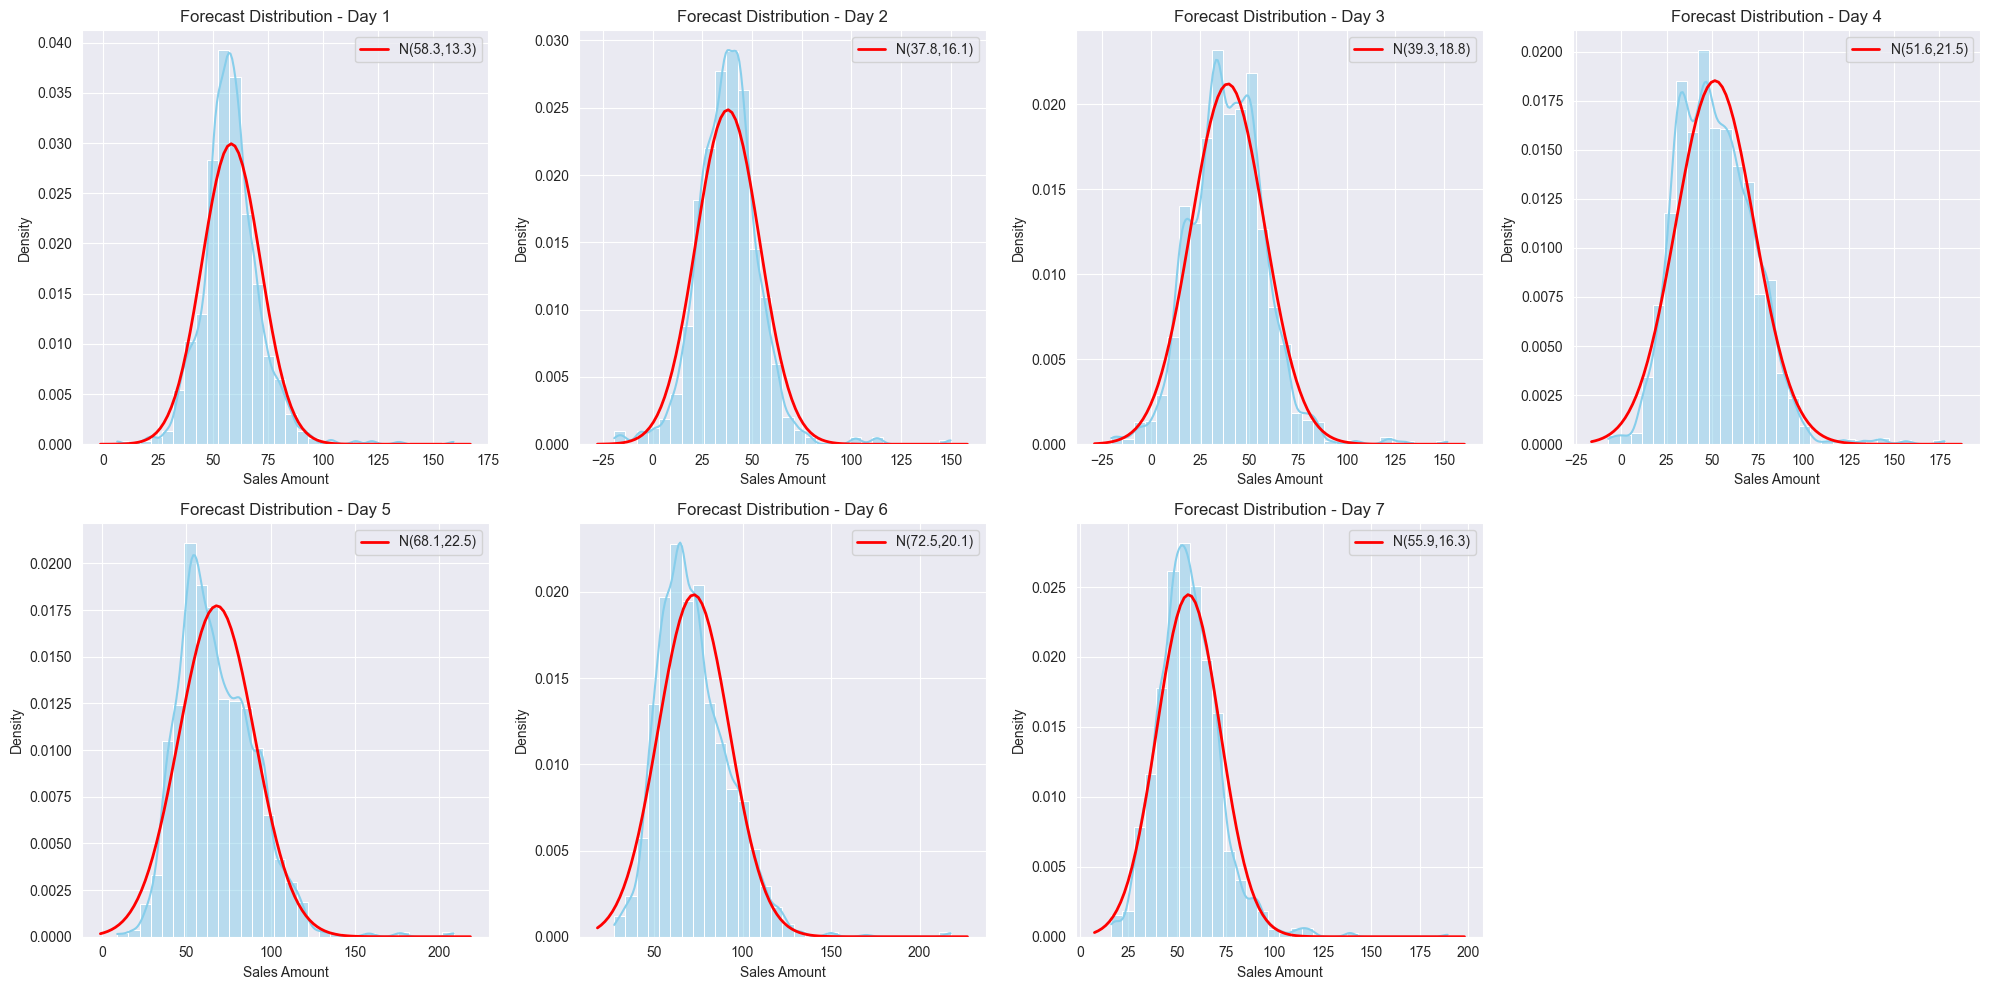

In [12]:
 # -------------------------
# 8. Visualize the Bootstrapped Forecast Distributions
# -------------------------
# Create subplots for each day’s forecast distribution.
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i in range(7):
    samples = bootstrap_forecasts_df[i]
    ax = axes[i]
    sns.histplot(samples, kde=True, ax=ax, stat="density", bins=30, color='skyblue')
    ax.set_title(f"Forecast Distribution - Day {i+1}")
    ax.set_xlabel("Sales Amount")
    ax.set_ylabel("Density")

    mu, std = stats.norm.fit(samples)
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    ax.plot(x, p, 'r', linewidth=2, label=f"N({mu:.1f},{std:.1f})")
    ax.legend()

if len(axes) > 7:
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [13]:
def plot_histogram(data, index):
    mean = np.mean(data)
    std = np.std(data)

    bin_count = int(np.sqrt(len(data)))
    plt.subplot(1,2,1)
    sns.histplot(data=data, bins=bin_count, kde=False, color='blue')
    index += 1
    plt.title(f"Sales Histogram of Day-{index}")
    plt.xlabel("Sales Quantity")
    plt.ylabel("Frequency")

def plot_distribution(data, index):
    mean = np.mean(data)
    std = np.std(data)

    plt.subplot(1,2,2)
    sns.kdeplot(data=data, fill=True, color='red')
    index += 1
    plt.title(f"Sales Distribution of Day-{index}")
    plt.xlabel("Sales Quantity")

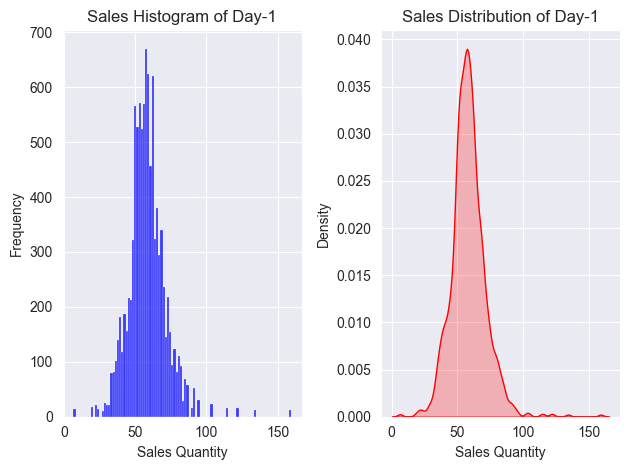

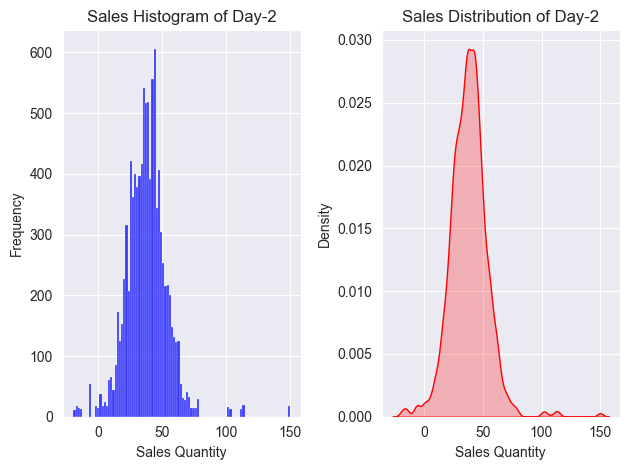

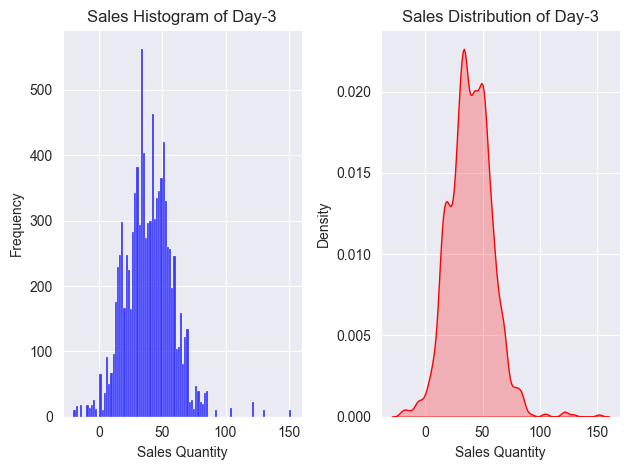

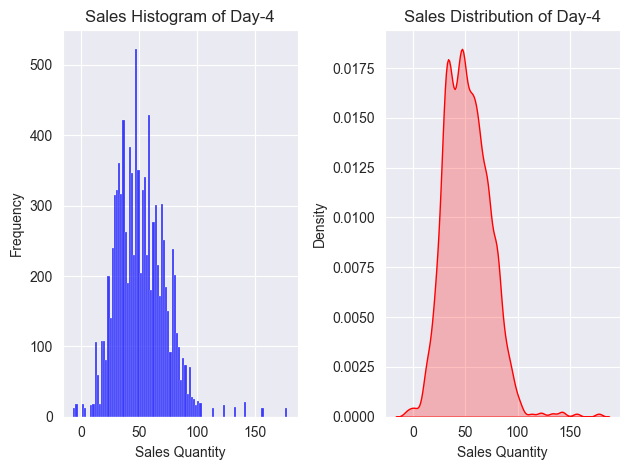

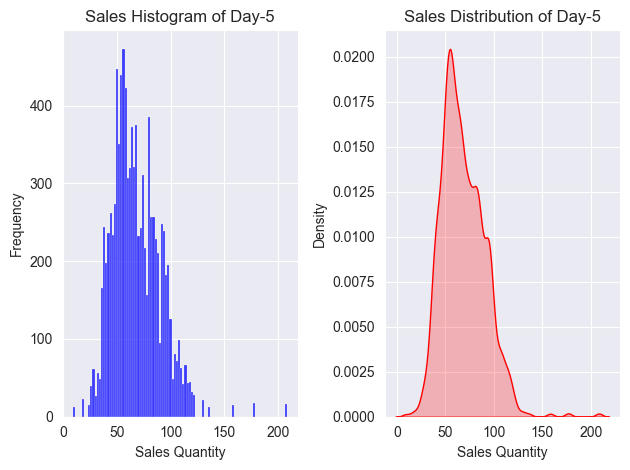

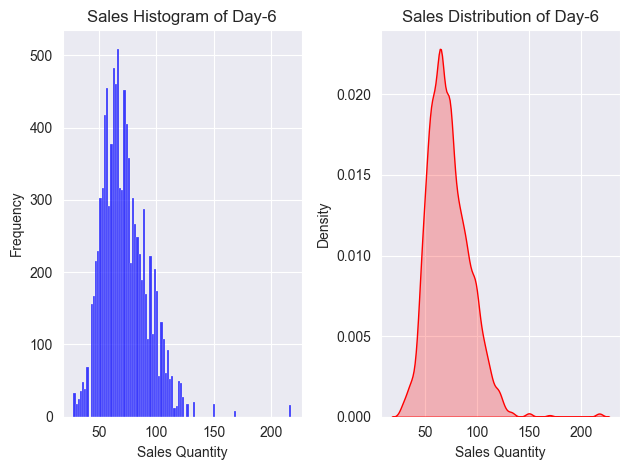

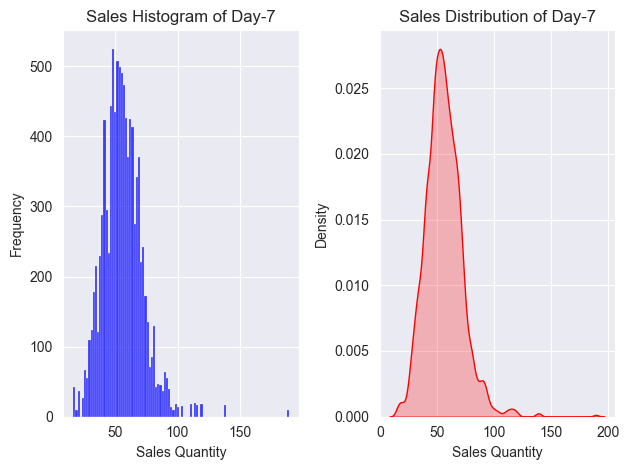

In [14]:
# Plot Histogram & Distribution
i = 0
for col in bootstrap_forecasts_df.columns:
    plot_histogram(bootstrap_forecasts_df[col], i)
    plot_distribution(bootstrap_forecasts_df[col], i)

    plt.tight_layout()
    plt.show()
    i += 1

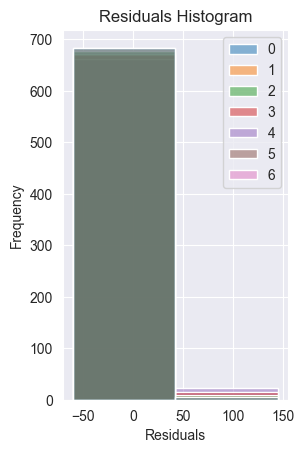

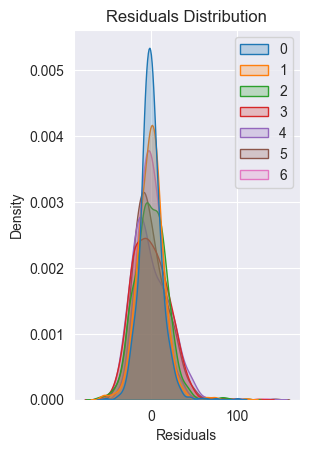

In [16]:
# -------------------------
# 9. Visualize the Residuals
# -------------------------
# Create a histogram plot and a distribution plot for residuals

data = errors_list
bin_count = int(np.sqrt(len(data)))
plt.subplot(1,2,1)
sns.histplot(data=data, bins=bin_count, kde=False, color='blue')
plt.title(f"Residuals Histogram")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

plt.show()

plt.subplot(1,2,2)
sns.kdeplot(data=data, fill=True, color='red')
plt.title(f"Residuals Distribution")
plt.xlabel("Residuals")

plt.show()